<a href="https://colab.research.google.com/github/karoline-juliana/posgrad_cienciadados/blob/main/Projeto_Serie_temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pós-Graduação em Especialização em Ciência de Dados


---------------------------------------------------------------
**Universidade Federal de Pernambuco - UFPE**

**Curso de Pós-Graduação em Ciência de Dados**

**Disciplina: PROGRAMAÇÃO PARA APRENDIZAGEM DE MÁQUINA**

**Discentes: Karoline J. Costa da Silva e Xadai Rudá**

**Docente: Prof. Dr. Cleber Zanchettin**

---------------------------------------------------------------

## Projeto da Disciplina

O projeto escolhido foi o **Store Sales - Time Series Forecasting**, cujo objetivo será prever as vendas para as milhares de famílias de produtos vendidas nas lojas Favorita localizadas no Equador. 

Os dados de treinamento incluem datas, informações da loja e do produto, se esse item estava sendo promovido, bem como os números de vendas. 

Arquivos adicionais incluem informações suplementares que podem ser úteis na construção de seus modelos.

O dataset pode ser visualizado nesse [link](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data). 

## Descrições dos arquivos e informações de campo dos dados

**```train.csv```**
* Os dados de treinamento, incluindo séries temporais de recursos **store_nbr**, **family** e **onpromotion**, bem como as vendas-alvo.
* **store_nbr** identifica a loja na qual os produtos são vendidos.
* **family** identifica o tipo de produto vendido.
* **sales** fornece o total de vendas de uma família de produtos em uma determinada loja em uma determinada data. Valores fracionários são possíveis, pois os produtos podem ser vendidos em unidades fracionadas (1,5 kg de queijo, por exemplo, em vez de 1 saco de batatas fritas).
* **onpromotion** fornece o número total de itens em uma família de produtos que estavam sendo promovidos em uma loja em uma determinada data.

**```test.csv```**
* Os dados de teste, com os mesmos recursos que os dados de treinamento. Iremos prever as vendas alvo para as datas neste arquivo.
* As datas nos dados de teste são para os 15 dias após a última data nos dados de treinamento.

**```sample_submission.csv```**
* Um arquivo de envio de amostra no formato correto.

**```stores.csv```**
* armazena metadados, incluindo **city**, **state**, **type** e **cluster**.
* **cluster** é um agrupamento de lojas semelhantes.

**```oil.csv```**
* Preço diário do petróleo. Inclui valores durante os prazos de dados de treinamento e teste. (O Equador é um país dependente do petróleo e sua saúde econômica é altamente vulnerável a choques nos preços do petróleo.)

**```holidays_events.csv```**
* Feriados e Eventos, com metadados
* NOTA: Atenção especial à coluna **transferred**. Um feriado que é transferido oficialmente cai nesse dia do calendário, mas foi transferido para outra data pelo governo. Um dia transferido é mais como um dia normal do que um feriado. Para encontrar o dia em que realmente foi comemorado, procure a linha correspondente onde type é Transfer. Por exemplo, o feriado Independência de Guayaquil foi transferido de 2012-10-09 para 2012-10-12, o que significa que foi comemorado em 2012-10-12. Os dias do tipo Bridge são dias extras adicionados a um feriado (por exemplo, para estender o intervalo em um fim de semana prolongado). Estes são frequentemente compostos pelo tipo Dia de Trabalho, que é um dia normalmente não agendado para o trabalho (por exemplo, sábado) que visa o retorno da Ponte.
* Feriados adicionais são dias adicionados a um feriado regular do calendário, por exemplo, como normalmente acontece em torno do Natal (tornando a véspera de Natal um feriado).

**Notas Adicionais**
* Os salários no setor público são pagos quinzenalmente no dia 15 e no último dia do mês. As vendas nos supermercados podem ser afetadas por isso.
* Um terremoto de magnitude 7,8 atingiu o Equador em 16 de abril de 2016. Pessoas se reuniram em esforços de ajuda doando água e outros produtos de primeira necessidade que afetaram muito as vendas dos supermercados por várias semanas após o terremoto.

# Importando os dados

Importamos as bibliotecas que serão utilizadas para o projeto.

In [ ]:
import pandas as pd
import datetime
import calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from learntools.time_series.style import *

from pathlib import Path
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go


Em seguida, fazemos o download dos datasets que foram utilizados.

In [ ]:
holiday_events = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/holidays_events.csv')
oil = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/oil.csv')
stores = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/stores.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/sample_submission.csv')
test = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/test.csv')
train = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/train.csv')
transactions = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/transactions.csv')

In [ ]:
print(holiday_events.info())
print(oil.info())
print(stores.info())
print(sample_submission.info())
print(test.info())
print(train.info())
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   

# Tratamento dos dados.

Optamos por concatenar todos os datasets para auxiliar na manipulação dos dados.

In [ ]:
df_data = pd.concat([train, test], sort = True)
df_data = df_data.merge(stores, how = 'left', on = 'store_nbr')
df_data = df_data.merge(oil, how = 'left', on = 'date')
df_data = df_data.merge(transactions, how = 'left', on = ['date', 'store_nbr'])
df_data = df_data.merge(holiday_events, how = 'left', on = 'date')
df_data = df_data.rename(columns={'type_x': 'store', 'type_y': 'holiday'})
df_data['date'] = pd.to_datetime(df_data['date'])

df_data['year'] = df_data['date'].dt.year
df_data['month'] = df_data['date'].dt.month
df_data['week'] = df_data['date'].dt.isocalendar().week
df_data['quarter'] = df_data['date'].dt.quarter
df_data['day_of_week'] = df_data['date'].dt.day_name()
#df_data.set_index('date', inplace=True)
df_data.head()

,date,family,id,onpromotion,sales,store_nbr,city,state,store,cluster,...,holiday,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,2013-01-01,AUTOMOTIVE,0,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
1,2013-01-01,BABY CARE,1,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
2,2013-01-01,BEAUTY,2,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
3,2013-01-01,BEVERAGES,3,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
4,2013-01-01,BOOKS,4,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday


Visualização das informações gerais sobre os atributos.

In [ ]:
print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3082860 entries, 0 to 3082859
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   family        object        
 2   id            int64         
 3   onpromotion   int64         
 4   sales         float64       
 5   store_nbr     int64         
 6   city          object        
 7   state         object        
 8   store         object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  transactions  float64       
 12  holiday       object        
 13  locale        object        
 14  locale_name   object        
 15  description   object        
 16  transferred   object        
 17  year          int64         
 18  month         int64         
 19  week          UInt32        
 20  quarter       int64         
 21  day_of_week   object        
dtypes: UInt32(1), datetime64[ns](1), float64(3), int64(7), object(10)


## Corrigindo os valores nulos.

In [ ]:
moving_average_oil = oil.rolling(
    window=365,       
    center=True,      
    min_periods=183,  
).median()              
moving_average_oil['date'] = oil['date']
moving_average_oil.loc[[0,1],'dcoilwtico'] = moving_average_oil.loc[2,'dcoilwtico']
moving_average_oil.date = pd.to_datetime(moving_average_oil.date)
df_yr_oil = oil[['date','dcoilwtico']]

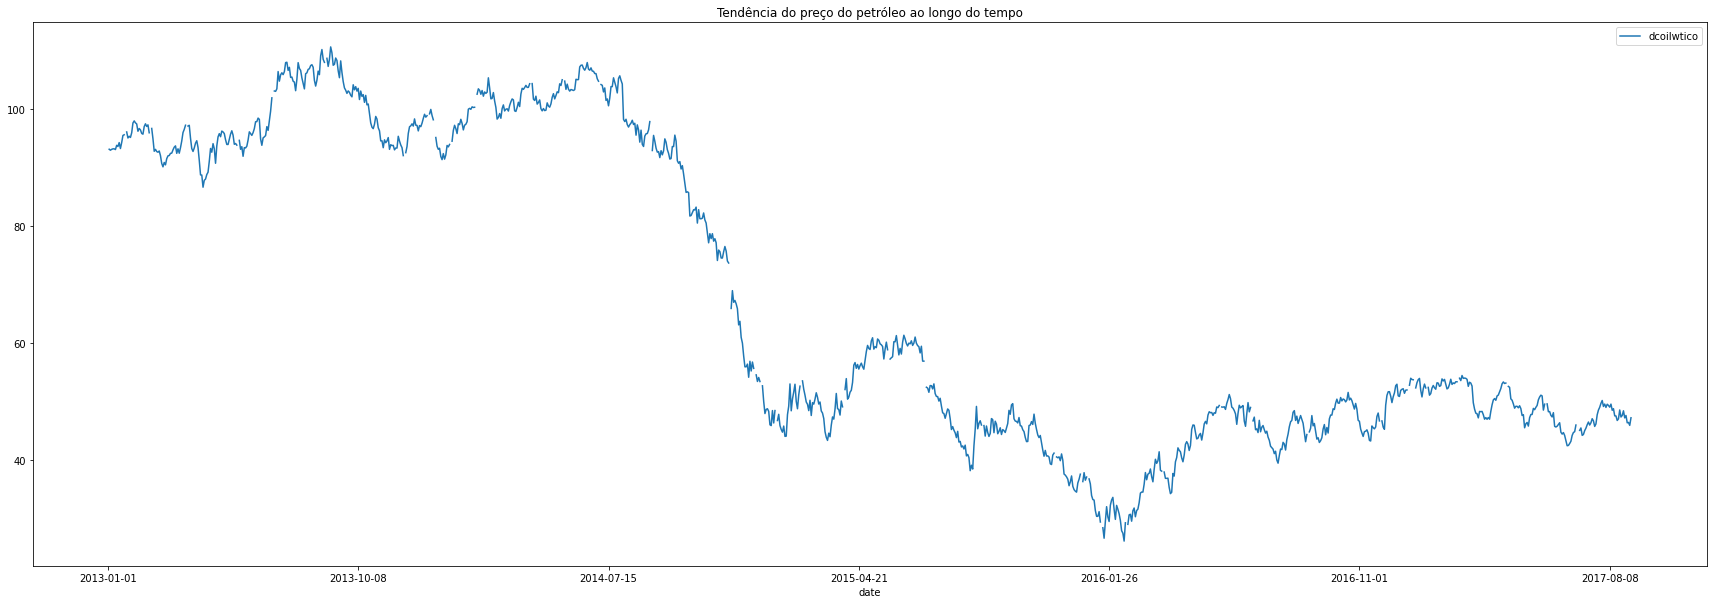

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (30,10))
df_yr_oil.plot.line(x="date",y="dcoilwtico", title = "Tendência do preço do petróleo ao longo do tempo", ax = axes)
plt.show();

In [ ]:
df_data['dcoilwtico'] = df_data['dcoilwtico'].fillna(method='bfill')
df_data.dcoilwtico.isnull().sum()

0

In [ ]:
df_data.transactions = df_data.transactions.replace(np.nan,0)

In [ ]:
df_data[['locale', 'locale_name', 'description']] = df_data[['locale', 'locale_name', 'description']].replace(np.nan,'')
df_data.holiday = df_data.holiday.replace(np.nan,'Working Day')
df_data.transferred = df_data.transferred.replace(np.nan,False)

In [ ]:
df_data

,date,family,id,onpromotion,sales,store_nbr,city,state,store,cluster,...,holiday,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,2013-01-01,AUTOMOTIVE,0,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
1,2013-01-01,BABY CARE,1,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
2,2013-01-01,BEAUTY,2,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
3,2013-01-01,BEVERAGES,3,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
4,2013-01-01,BOOKS,4,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082855,2017-08-31,POULTRY,3029395,1,NaN,9,Quito,Pichincha,B,6,...,Working Day,,,,False,2017,8,35,3,Thursday
3082856,2017-08-31,PREPARED FOODS,3029396,0,NaN,9,Quito,Pichincha,B,6,...,Working Day,,,,False,2017,8,35,3,Thursday
3082857,2017-08-31,PRODUCE,3029397,1,NaN,9,Quito,Pichincha,B,6,...,Working Day,,,,False,2017,8,35,3,Thursday
3082858,2017-08-31,SCHOOL AND OFFICE SUPPLIES,3029398,9,NaN,9,Quito,Pichincha,B,6,...,Working Day,,,,False,2017,8,35,3,Thursday


# EDA - Análise Exploratória de Dados

### Análise média das vendas

In [ ]:
# data
# Agrupamos por tipo de loja, e adicionamos ao DataFrame um único campo 'vendas' com a média dos preços de venda ordenados de forma crescente
df_st_sa = df_data[:train.shape[0]].groupby('store').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_fa_sa = df_data[:train.shape[0]].groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_cl_sa = df_data[:train.shape[0]].groupby('cluster').agg({"sales" : "mean"}).reset_index() 

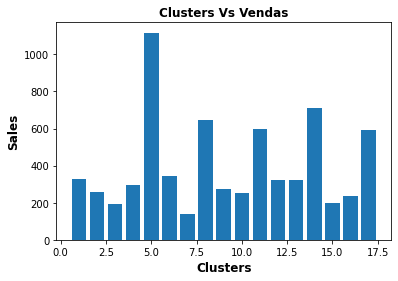

In [ ]:
plt.bar(df_cl_sa.cluster, df_cl_sa.sales)
plt.title('Clusters Vs Vendas', fontsize=12, fontweight='bold')
plt.ylabel('Sales', fontsize=12, fontweight='bold')
plt.xlabel('Clusters', fontsize=12, fontweight='bold')
plt.xticks(rotation=360)
plt.show();

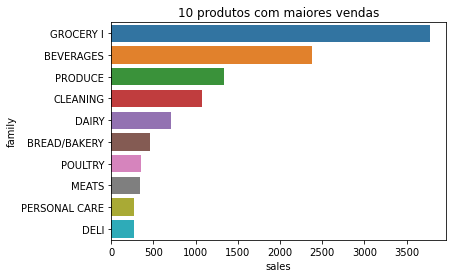

In [ ]:
sns.barplot(x = df_fa_sa.sales, y = df_fa_sa.family, data = df_fa_sa).set_title("10 produtos com maiores vendas");

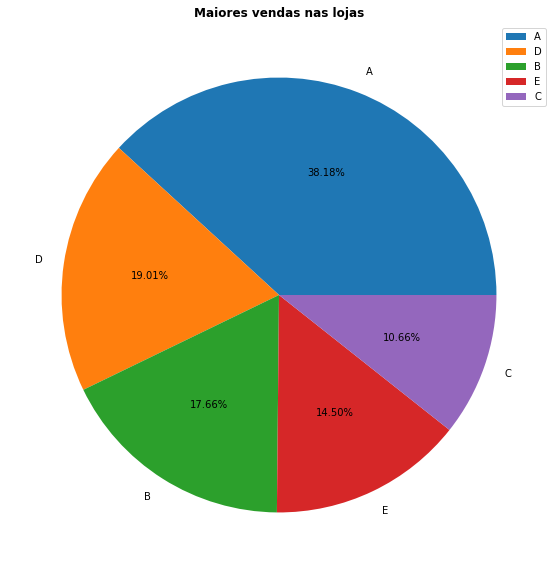

In [ ]:
plt.figure(figsize = (20,10))
plt.pie(df_st_sa.sales, labels = df_st_sa.store, autopct='%1.2f%%')
plt.legend()
plt.title('Maiores vendas nas lojas', fontsize=12, fontweight='bold')
plt.show();

As vendas mais altas são feitas por produtos como **mercearia** e **bebidas**. A **loja A** tem as vendas mais altas, com **38%**.

In [ ]:
# data 
df_2013 = df_data[df_data['year']==2013][:train.shape[0]][['month','sales']]
df_2013 = df_2013.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s13'})
df_2014 = df_data[df_data['year']==2014][:train.shape[0]][['month','sales']]
df_2014 = df_2014.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s14'})
df_2015 = df_data[df_data['year']==2015][:train.shape[0]][['month','sales']]
df_2015 = df_2015.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s15'})
df_2016 = df_data[df_data['year']==2016][:train.shape[0]][['month','sales']]
df_2016 = df_2016.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s16'})
df_2017 = df_data[df_data['year']==2017][:train.shape[0]][['month','sales']]
df_2017 = df_2017.groupby('month').agg({"sales" : "mean"}).reset_index()
df_2017_no = pd.DataFrame({'month': [9,10,11,12], 'sales':[0,0,0,0]})
df_2017 = df_2017.append(df_2017_no).rename(columns={'sales':'s17'})
df_year = df_2013.merge(df_2014,on='month').merge(df_2015,on='month').merge(df_2016,on='month').merge(df_2017,on='month')

# Valor do eixo X 
df_year = df_year[['s13','s14','s15','s16','s17']].replace(np.nan,0)
x_data = df_year.values

# valor do eixo y (mês)
df_2013['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_2013['month'].tolist()


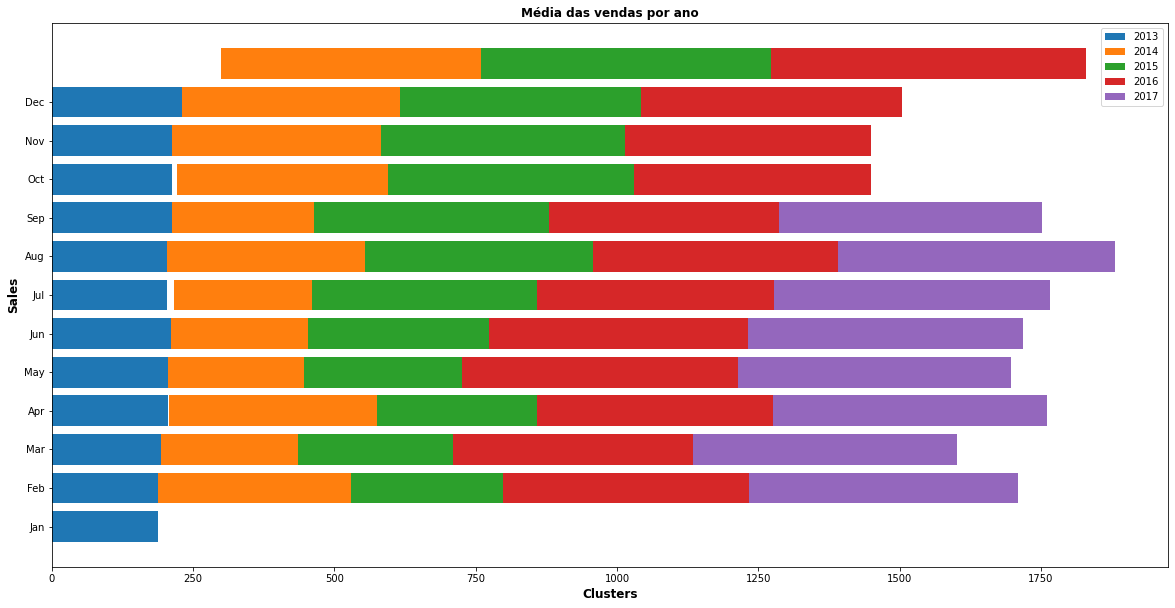

In [ ]:
plt.figure(figsize = (20,10))

plt.barh(df_2013.month, df_2013.s13, data = df_2013)
plt.barh(df_2014.month, df_2014.s14, left = df_2013.s13, data = df_2014)
plt.barh(df_2015.month, df_2015.s15, left = df_2013.s13 + df_2014.s14, data = df_2015)
plt.barh(df_2016.month, df_2016.s16, left = df_2013.s13 + df_2014.s14 + df_2015.s15, data = df_2016)
plt.barh(df_2017.month, df_2017.s17, left = df_2013.s13 + df_2014.s14 + df_2015.s15 + df_2016.s16, data = df_2017)
plt.title('Média das vendas por ano', fontsize=12, fontweight='bold')
plt.ylabel('Sales', fontsize=12, fontweight='bold')
plt.xlabel('Clusters', fontsize=12, fontweight='bold')
plt.xticks(rotation=360)
plt.legend((2013,2014,2015,2016,2017))
plt.show();

As vendas mais altas são feitas no mês de **dezembro** e depois diminuem em janeiro. As vendas estão aumentando gradativamente de **2013 a 2017**. 

Obs.: Não temos dados nos meses entre setembro e dezembro de 2017.

In [ ]:
# data
df_m_sa = df_data[:train.shape[0]].groupby('month').agg({"sales" : "mean"}).reset_index()
df_m_sa['sales'] = round(df_m_sa['sales'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['sales'].astype(str) 

df_w_sa = df_data[:train.shape[0]].groupby('week').agg({"sales" : "mean"}).reset_index() 
df_q_sa = df_data[:train.shape[0]].groupby('quarter').agg({"sales" : "mean"}).reset_index() 

Text(0.5, 1.0, 'Análise de vendas média mensal')

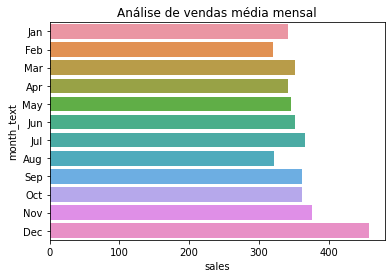

In [ ]:
sns.barplot(x = df_m_sa.sales, y = df_m_sa.month_text, data = df_m_sa).set_title("Análise de vendas média mensal")

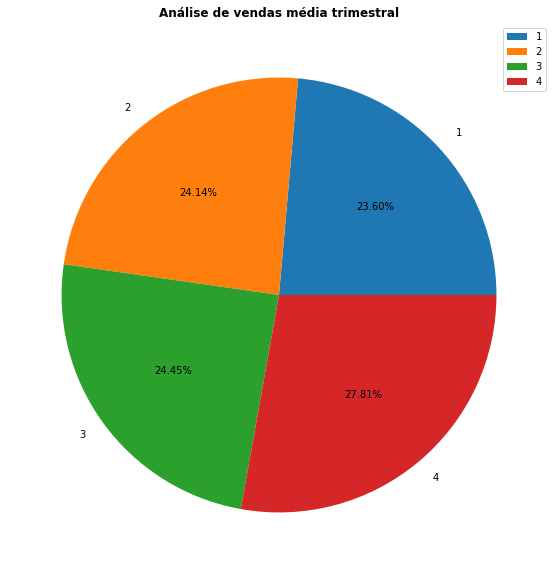

In [ ]:
plt.figure(figsize = (10,10))
plt.pie(df_q_sa.sales, labels = df_q_sa.quarter, autopct='%1.2f%%')
plt.legend()
plt.title('Análise de vendas média trimestral', fontsize=12, fontweight='bold')
plt.show();

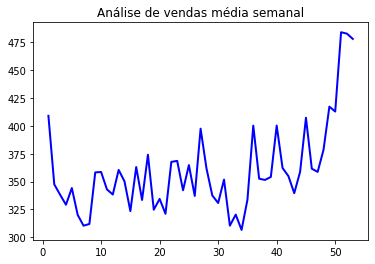

In [ ]:
plt.plot(df_w_sa.week, df_w_sa.sales, color='blue', linewidth=2)
plt.title('Análise de vendas média semanal');

As maiores vendas são feitas no **último trimestre** do ano, seguido pelo terceiro. Aquele com menos vendas é o primeiro.

In [ ]:
# data
df_dw_sa = df_data[:train.shape[0]].groupby('day_of_week').agg({"sales" : "mean"}).reset_index()
df_dw_sa.sales = round(df_dw_sa.sales, 2)

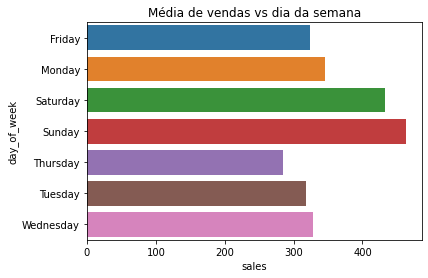

In [ ]:
sns.barplot(x = df_dw_sa.sales, y = df_dw_sa.day_of_week, data = df_dw_sa).set_title("Média de vendas vs dia da semana");

Maiores vendas são feitas no **fim de semana**. Surpreendentemente, as segundas-feiras são o terceiro dia com mais vendas.

In [ ]:
df_train = df_data[:train.shape[0]][['state','sales','store','year']]

Text(0.5, 1.0, 'Estado vs Vendas da Loja A (por ano)')

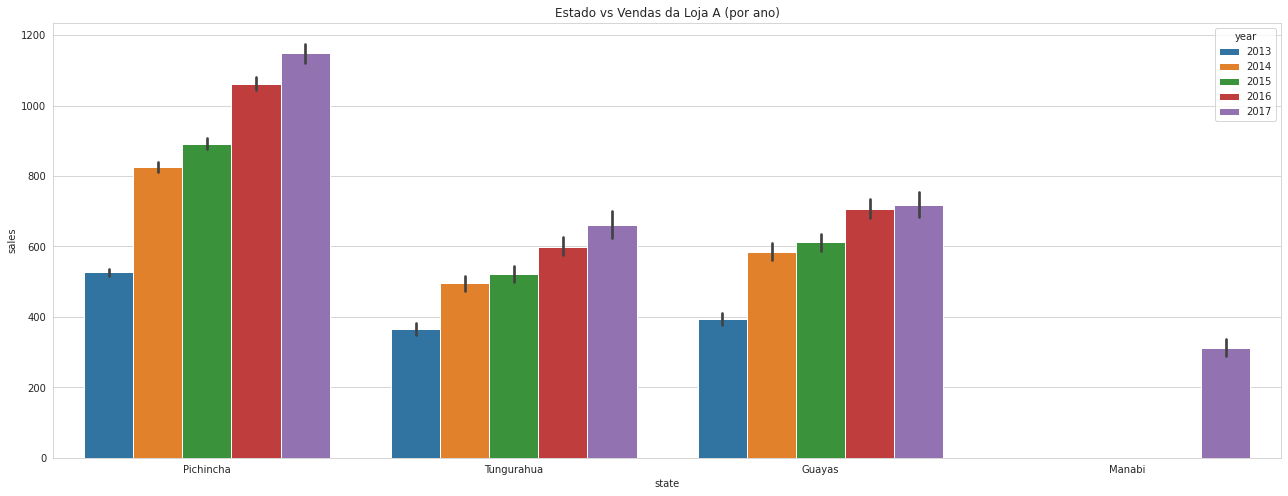

In [ ]:
fig = plt.figure(figsize=(22,8))
sns.set_style('whitegrid')
sns.barplot(x='state',y='sales',hue = 'year', data=df_train[df_train['store'] == 'A'])
plt.title("Estado vs Vendas da Loja A (por ano)");

As maiores vendas são feitas no estado de **Pichincha**. As vendas aumentaram durante o período registrado em todos os estados, exceto Manabi, onde a Loja A é nova em 2017.

# Componentes da Série Temporal (Tendência, Sazonalidade, Decomposição)

Se assumirmos uma **decomposição aditiva**, então podemos escrever $y_{t} = S_{t} + T_{t} + R_{t}$, onde $y_{t}$ é os dados, $S_{t}$ é o componente sazonal, $T_{t}$ é o componente do ciclo de tendência e $R_{t}$ é o componente residual, tudo no tempo 𝑡. Além disso, para uma **decomposição multiplicativa**, temos $y_{t} = S_{t} * T_{t} * R_{t}$.

A decomposição aditiva é a mais adequada se a magnitude das flutuações sazonais, ou a variação em torno do ciclo de tendência, não varia com o nível da série temporal. 

Quando a variação no padrão sazonal, ou a variação em torno do ciclo de tendência, parece ser proporcional ao nível da série temporal, então uma decomposição multiplicativa é mais apropriada. 

Decomposições multiplicativas são comuns com séries temporais econômicas.

### Tendência

O componente de tendência de uma série temporal representa uma mudança persistente e de longo prazo na média da série. A tendência é a parte mais lenta de uma série, a parte que representa a maior escala de tempo de importância. Em uma série temporal de vendas de produtos, uma tendência crescente pode ser o efeito de uma expansão do mercado, à medida que mais pessoas tomam conhecimento do produto ano a ano.

In [ ]:
# Gráfico de média móvel
sales = df_data[:train.shape[0]].groupby('date').agg({"sales" : "mean"}).reset_index()
sales.set_index('date',inplace=True)
moving_average = sales.rolling(
    window=365,       
    center=True,      
    min_periods=183,  
).mean()              
moving_average['date'] = sales.index

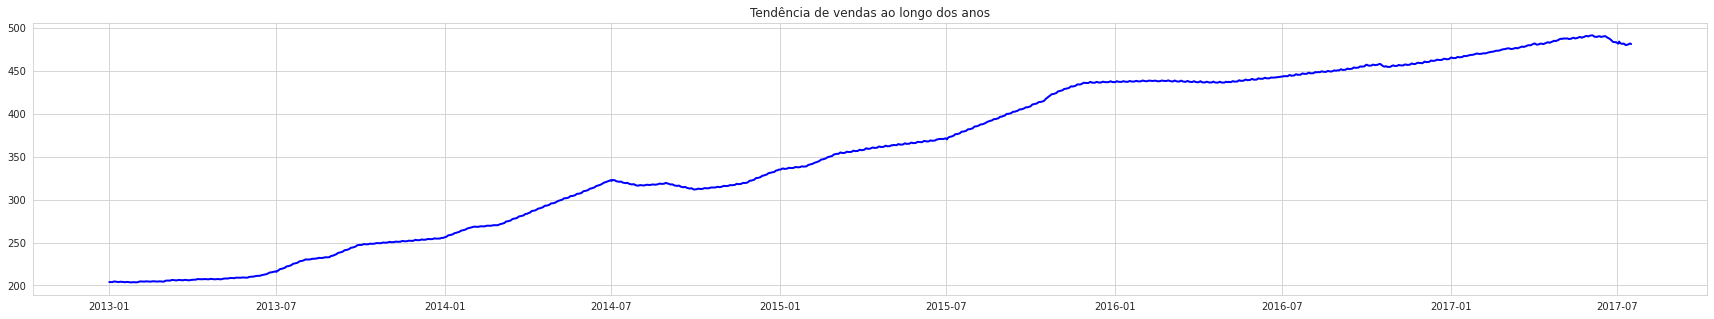

In [ ]:
plt.figure(figsize = (30,5))
plt.plot(moving_average.date, moving_average.sales, color='blue', linewidth=2)
plt.title('Tendência de vendas ao longo dos anos')
plt.show();

Para calcular uma média móvel de uma série temporal, calculamos a média dos valores dentro de uma janela deslizante de uma largura definida. Cada ponto no gráfico representa a média de todos os valores da série que se enquadram na janela de cada lado. A ideia foi suavizar quaisquer flutuações de curto prazo na série para que apenas as mudanças de longo prazo permaneçam.

As vendas têm uma tendência de **aumento** constante durante os anos registrados.

### Sazonalidade

Dizemos que uma série temporal exibe sazonalidade sempre que há uma mudança regular e periódica na média da série. As mudanças sazonais geralmente seguem o relógio e o calendário - repetições ao longo de um dia, uma semana ou um ano são comuns. 

A sazonalidade é muitas vezes impulsionada pelos ciclos do mundo natural ao longo de dias e anos ou por convenções de comportamento social em torno de datas e horas (feriados e datas comemorativas).

In [ ]:
store_sales = pd.read_csv(
    '/content/drive/MyDrive/store-sales-time-series-forecasting/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    }, parse_dates=['date'])
store_sales.date = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    #.loc['2017']
)

In [ ]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

Text(0.5, 1.0, 'Plot Sazonal (ano/diadoano)')

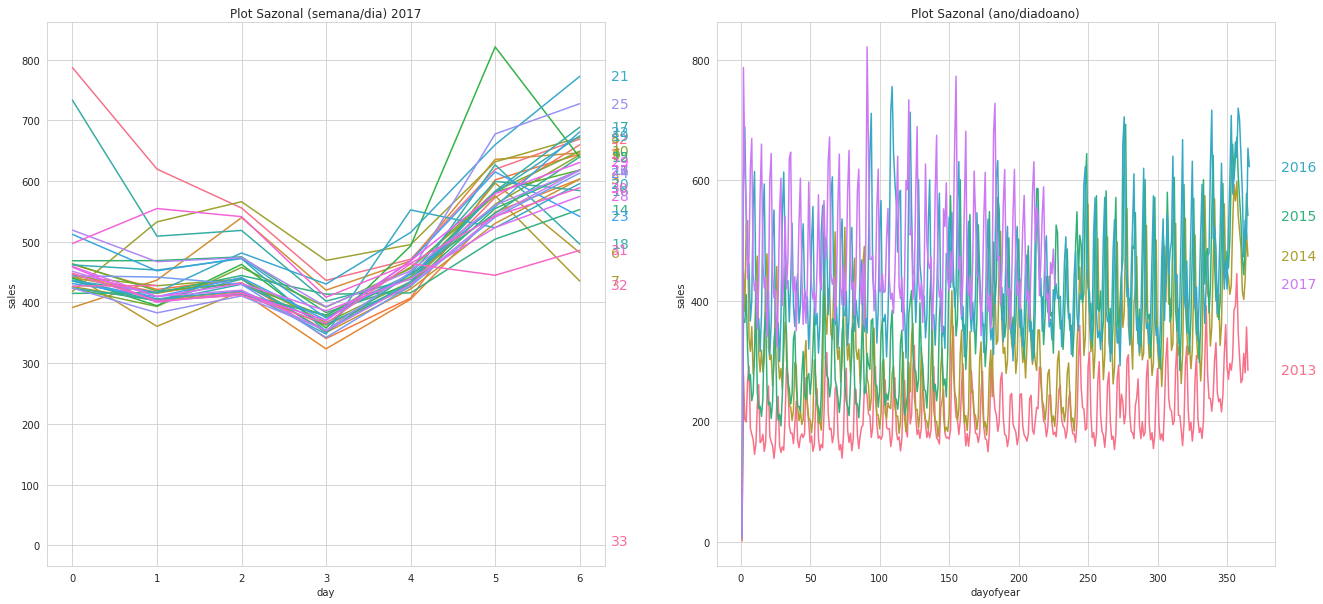

In [ ]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
X['year'] = X.index.year
X['dayofyear'] = X.index.dayofyear


fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(22, 10))
seasonal_plot(X.loc['2017'], y='sales', period="week", freq="day", ax=ax0)
ax0.set_title('Plot Sazonal (semana/dia) 2017')
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);
ax1.set_title('Plot Sazonal (ano/diadoano)')

O gráfico sazonal sugerem uma forte sazonalidade semanal e uma fraca sazonalidade anual. De fato, as notas do conjunto de dados de vendas nas lojas dizem que os salários no setor público são pagos quinzenalmente, no 15º e último dia do mês – uma possível origem para essas temporadas.

### Decomposição

Combinamos todos os recursos das séries temporais acima em um único gráfico.

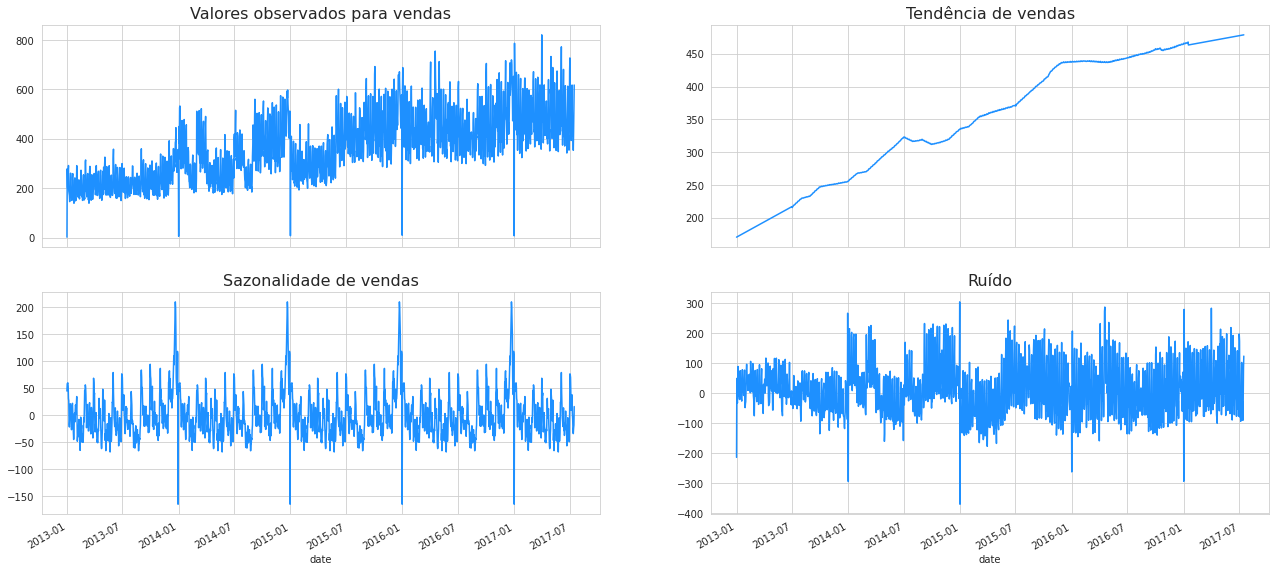

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(sales['sales'], period=365, model='additive', extrapolate_trend='freq')
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(22,10))
ax[0,0].set_title('Valores observados para vendas', fontsize=16)
decomp.observed.plot(ax = ax[0,0], legend=False, color='dodgerblue')

ax[0,1].set_title('Tendência de vendas', fontsize=16)
decomp.trend.plot(ax = ax[0,1],legend=False, color='dodgerblue')

ax[1,0].set_title('Sazonalidade de vendas', fontsize=16)
decomp.seasonal.plot(ax = ax[1,0],legend=False, color='dodgerblue')

ax[1,1].set_title('Ruído', fontsize=16)
decomp.resid.plot(ax = ax[1,1],legend=False, color='dodgerblue')

Podemos ver que o componente sazonal muda lentamente ao longo do tempo. Mas isso não significa que anos antes e após não terão padrões sazonais diferentes.

O componente residual mostrado no painel inferior "Ruído" é o que sobra quando os componentes sazonais e de ciclo de tendência são subtraídos dos dados.

### Estacionaridade

Uma Série Temporal estacionária é aquela cujas propriedades não dependem do tempo em que a série é observada. Assim, séries temporais com tendências, ou com sazonalidade, não são estacionárias. Uma série temporal com comportamento cíclico (mas sem tendência ou sazonalidade) é estacionária.

A estacionaridade é importante, pois as séries não estacionárias que dependem do tempo têm muitos parâmetros a serem considerados ao modelar a série temporal. O método diff() pode facilmente converter uma série não estacionária em uma série estacionária.

In [ ]:
# Checando a estacionaridade
def adf_test(series, title=''):
    print('Teste Dickey-Fuller Aumentado: {}'.format(title))
    # .dropna() lida com dados diferenciados
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['Estatística de teste ADF','p-value','# atrasos usados','# observações']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['valor crítico ({})'.format(key)]=val
        
    # .to_string() remove a linha "dtype: float64"
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Forte evidência contra a hipótese nula")
        print("Rejeitar a hipótese nula")
        print("Os dados não têm raiz unitária e são estacionários")
    else:
        print("Evidência fraca contra a hipótese nula")
        print("Falha ao rejeitar a hipótese nula")
        print("Os dados têm uma raiz unitária e não são estacionários")

In [ ]:
# Agregando a série temporal a um índice escalonado mensalmente
y = df_data[['date','sales']].copy()
y.set_index('date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
        
adf_test(y['sales'],title='') 

Teste Dickey-Fuller Aumentado: 
Estatística de teste ADF    -1.581928
p-value                      0.492665
# atrasos usados             1.000000
# observações               54.000000
valor crítico (1%)          -3.557709
valor crítico (5%)          -2.916770
valor crítico (10%)         -2.596222
Evidência fraca contra a hipótese nula
Falha ao rejeitar a hipótese nula
Os dados têm uma raiz unitária e não são estacionários


Se os dados não são estacionários, mas queremos usar um modelo como o ARIMA (que requer essa característica), os dados devem ser transformados. Vamos transformar a tendência de vendas de não estacionaridade para estacionaridade usando o método diff:

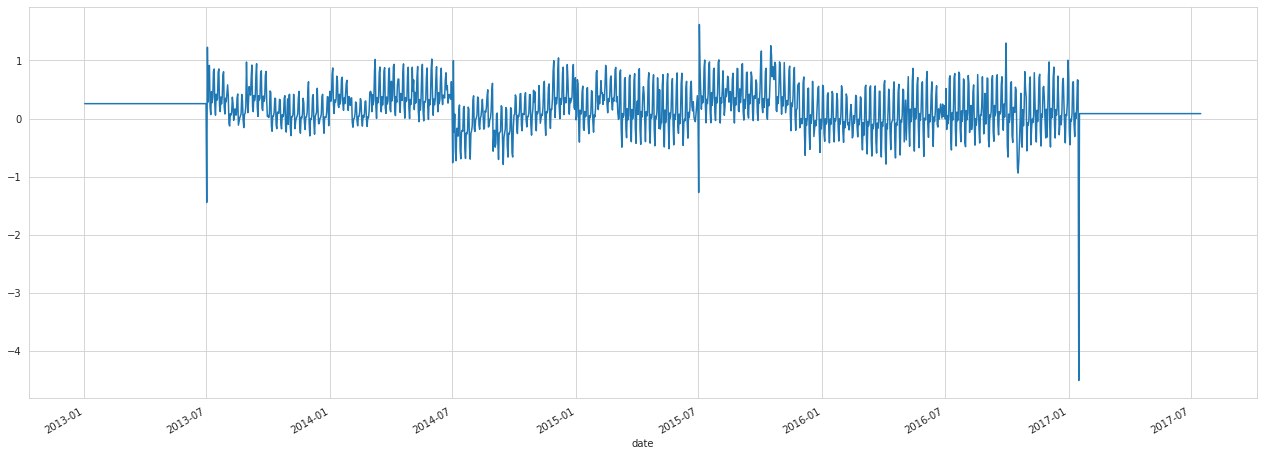

In [ ]:
fig = plt.figure(figsize=(22,8))
decomp.trend.diff().plot()

# Transformação dos atributos

### Rotulando atributos não numéricos usando LabelEncoder. 

Vamos converter recursos não numéricos em tipo numérico com LabelEncoder, que basicamente rotula as classes de 0 a n. Esse processo é necessário para que os modelos aprendam com esses recursos.

In [ ]:
non_numerical_cols =  [col for col in df_data.columns if df_data[col].dtype == 'object']
for feature in non_numerical_cols:        
    df_data[feature] = LabelEncoder().fit_transform(df_data[feature])
df_data.head().style.set_properties(subset=non_numerical_cols, **{'background-color': '#F1C40F'})

,date,family,id,onpromotion,sales,store_nbr,city,state,store,cluster,dcoilwtico,transactions,holiday,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,2013-01-01 00:00:00,0,0,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5
1,2013-01-01 00:00:00,1,1,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5
2,2013-01-01 00:00:00,2,2,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5
3,2013-01-01 00:00:00,3,3,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5
4,2013-01-01 00:00:00,4,4,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5


In [ ]:
df_data.dtypes

date            datetime64[ns]
family                   int64
id                       int64
onpromotion              int64
sales                  float64
store_nbr                int64
city                     int64
state                    int64
store                    int64
cluster                  int64
dcoilwtico             float64
transactions           float64
holiday                  int64
locale                   int64
locale_name              int64
description              int64
transferred               bool
year                     int64
month                    int64
week                    UInt32
quarter                  int64
day_of_week              int64
dtype: object

### One Hot Encoding

Para finalizar, vamos a um recurso não-ordinal One Hot Enconding. Todos os recursos rotulados acima são recursos não-ordinais. Portanto, mudamos para One Hot Enconding aqueles que têm uma baixa cardinalidade.

In [ ]:
low_card_cols = [col for col in non_numerical_cols if len(df_data[col].unique()) < 15]

In [ ]:
encoded_features = []

for feature in low_card_cols:
    encoded_feat = OneHotEncoder().fit_transform(df_data[feature].values.reshape(-1, 1)).toarray()
    n = df_data[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df_data.index
    encoded_features.append(encoded_df)

df_data = pd.concat([df_data, *encoded_features[:9]], axis=1)

In [ ]:
df_data.head().style.set_properties(subset=low_card_cols, **{'background-color': '#F1C40F'})

,date,family,id,onpromotion,sales,store_nbr,city,state,store,cluster,dcoilwtico,transactions,holiday,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week,store_1,store_2,store_3,store_4,store_5,holiday_1,holiday_2,holiday_3,holiday_4,holiday_5,holiday_6,holiday_7,locale_1,locale_2,locale_3,locale_4,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7
0,2013-01-01 00:00:00,0,0,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,2013-01-01 00:00:00,1,1,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,2013-01-01 00:00:00,2,2,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
3,2013-01-01 00:00:00,3,3,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,2013-01-01 00:00:00,4,4,0,0.000000,1,18,12,3,13,93.140000,0.000000,3,2,5,51,False,2013,1,1,1,5,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [ ]:
df_data = df_data.drop(low_card_cols,axis=1)

# Modelagem

### Cross Validation

Antes de tudo, vimos como funciona a técnica de validação cruzada na Análise de Série Temporal.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
N_SPLITS = 3

X = df_data['date']
y = df_data['sales']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

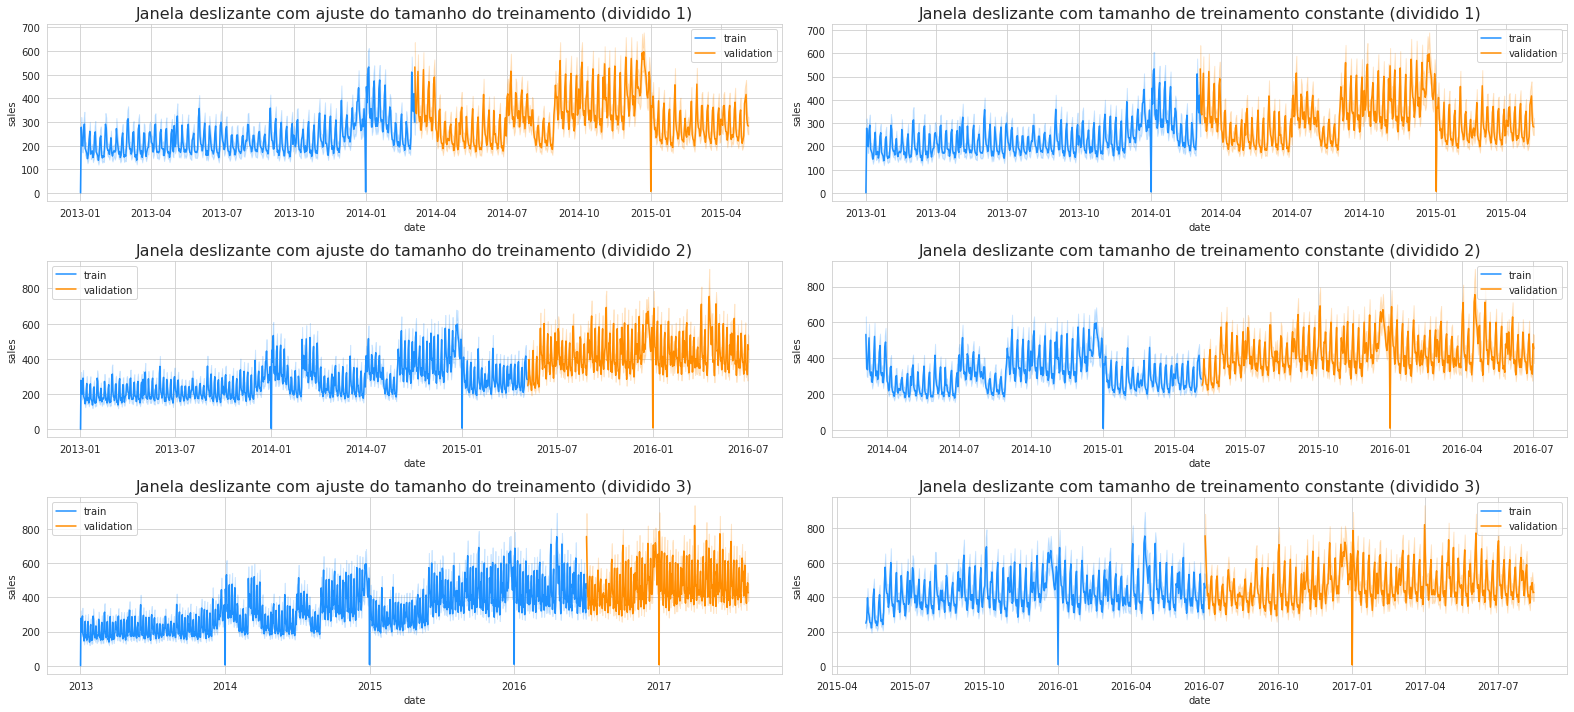

In [ ]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(22, 10))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Janela deslizante com ajuste do tamanho do treinamento (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Janela deslizante com tamanho de treinamento constante (Split {i+1})", fontsize=16)

plt.tight_layout()
plt.show()

### Análise de Série Temporal Univariada

Série temporal univariada: apenas uma variável está variando ao longo do tempo. 

**Prophet**:

O modelo que utilizamos é o Facebook Prophet. Prophet, ou “Facebook Prophet”, é uma biblioteca de código aberto para previsão de séries temporais univariadas (uma variável) desenvolvida pelo Facebook. O Prophet implementa o que eles chamam de modelo de previsão de série temporal aditiva, e a implementação suporta tendências, sazonalidade e feriados. Nesse caso, vamos usá-lo para mostrar as vendas médias por dia (é uma série temporal univariada).

In [ ]:
# Instalando a biblioteca do modelo
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 97 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.8 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638663 sha256=287414ec166c60b0081a825abc51ea21adf3ea4a0aca2a527d4542f12876c120
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.7
    Uninstalling cmdstanpy-1.0.7:
      Successfully uninstalled cmdstanpy-1.0.7
ERROR: pip's dependency resolver does not currently take into account all the p

In [ ]:
# Download da Biblioteca
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from fbprophet import Prophet

train = df_data[df_data['date']<= datetime.datetime(2017,8,15)][['date','sales']].groupby('date').mean().reset_index('date')
train.columns = ['ds', 'y']
x_valid = pd.DataFrame(df_data[df_data['date']>= datetime.datetime(2017,8,16)]['date'])
x_valid.columns = ['ds']

# Treinando o modelo
model = Prophet(daily_seasonality=True)
model.fit(train)
y_pred = model.predict(x_valid)

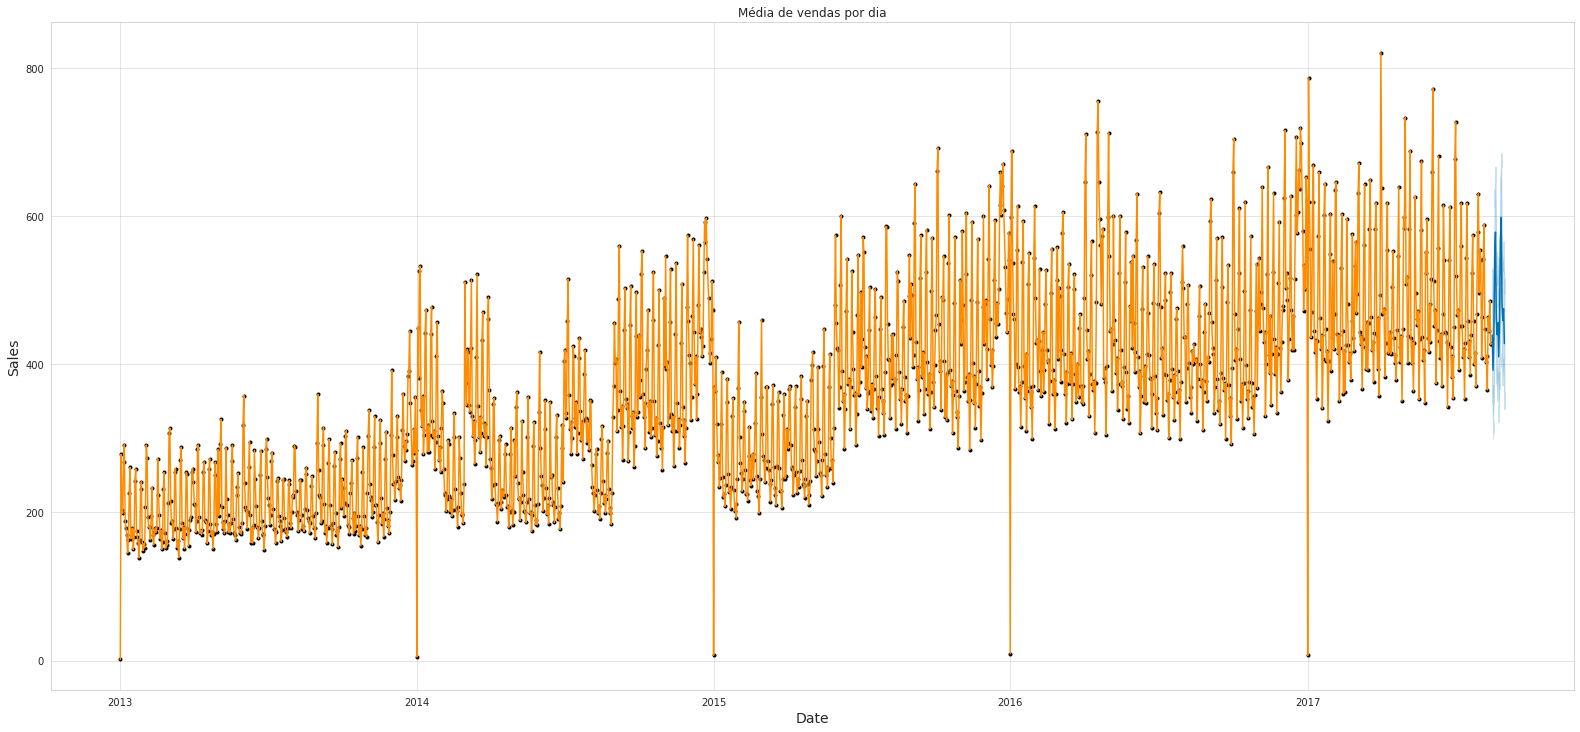

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(22)

model.plot(y_pred, ax=ax)
sns.lineplot(x=train['ds'], y=train['y'], ax=ax, color='darkorange') 

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)
ax.set_title('Média de vendas por dia')

plt.show();

### Análise de Série Temporal Multivariada

Por fim, vamos analisar a previsão multivariada da Série Temporal.

Séries temporais multivariadas: Várias variáveis estão variando ao longo do tempo.

In [ ]:
train_multivariate = df_data[df_data['date']<= datetime.datetime(2017,8,15)][['date','sales','dcoilwtico']].groupby('date').mean().reset_index('date')
train_multivariate.columns = ['ds', 'y','dcoilwtico']
x_valid = pd.DataFrame(df_data[df_data['date']>= datetime.datetime(2017,8,16)][['date','dcoilwtico']])
x_valid.columns = ['ds','dcoilwtico']

# Treinando o modelo
model_multivariate = Prophet(daily_seasonality=True)
model_multivariate.add_regressor('dcoilwtico')

model_multivariate.fit(train_multivariate)
y_pred_multivariate = model_multivariate.predict(x_valid)

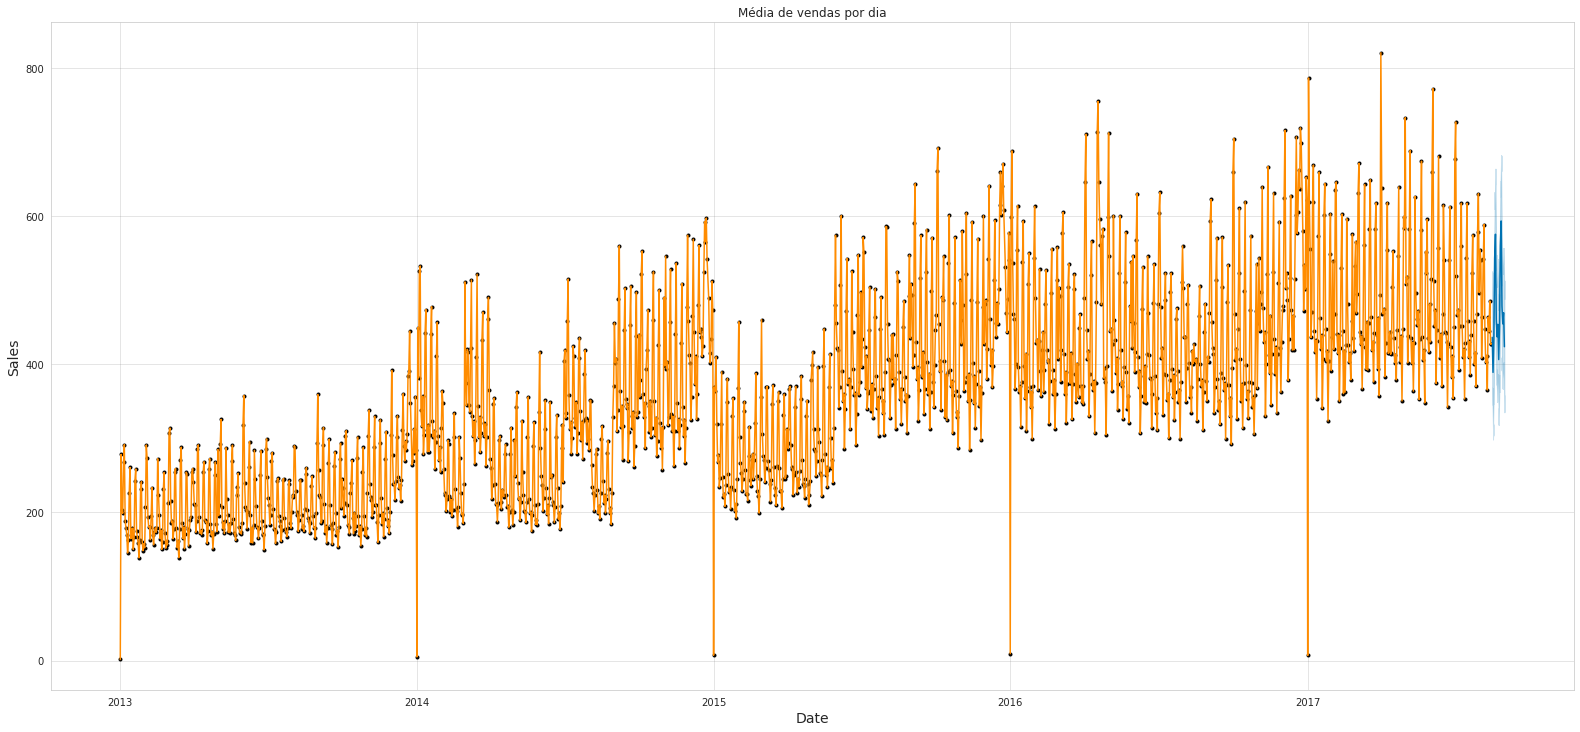

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(22)

model.plot(y_pred_multivariate, ax=ax)
sns.lineplot(x=train_multivariate['ds'], y=train_multivariate['y'], ax=ax, color='darkorange')

#ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)
ax.set_title('Média de vendas por dia')

plt.show();